# Re-train after AWS Deployment and identifying high quantities of FP

-----

### Import Libs

In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
import os
import numpy as np
from glob import glob
import glob
import random
#import imageio
import imageio.v2 as imageio  # Explicitly use version 2 API
from torchvision import transforms
from collections import defaultdict

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torchmetrics import JaccardIndex

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import jaccard_score
from PIL import Image

from transformers import get_cosine_schedule_with_warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau

import re
import shutil

import importlib
import gc
import S7_tools


In [3]:
# Set the Multiprocessing Start Method for Windows
import torch.multiprocessing as mp

if __name__ == "__main__":
    mp.set_start_method('spawn', force=True)

# Set a known seed
seed = 23
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)


### CUDA configuration

In [5]:
print(70*'-')
print("CUDA available:", torch.cuda.is_available())
current_device = torch.cuda.current_device()
print("GPU Model:", torch.cuda.get_device_name(current_device))
print("CUDA Version:", torch.version.cuda)
print(70*'-')

device_properties = torch.cuda.get_device_properties(current_device)
print("\nDevice Properties:")
print("  Name:", device_properties.name)
print("  Total Memory (GB):", device_properties.total_memory / (1024 ** 3))  # Convert bytes to GB
print("  Multiprocessors:", device_properties.multi_processor_count)
print("  Compute Capability:", device_properties.major, ".", device_properties.minor)
print(70*'-')

----------------------------------------------------------------------
CUDA available: True
GPU Model: NVIDIA GeForce GTX 1080 Ti
CUDA Version: 11.8
----------------------------------------------------------------------

Device Properties:
  Name: NVIDIA GeForce GTX 1080 Ti
  Total Memory (GB): 10.999755859375
  Multiprocessors: 28
  Compute Capability: 6 . 1
----------------------------------------------------------------------


## Data Access

In [10]:
# Function to extract the numeric value from filenames
def numeric_sort_key(filepath):
    # Extract numbers from the filename using a regular expression
    match = re.search(r'\d+', filepath)
    # Return the integer value of the number if found, otherwise 0
    return int(match.group()) if match else 0

# Get all the image and mask paths and sort them numerically
folder_data_train = sorted(
    glob.glob("../../UCSD_MLBootcamp_Capstone/5-Data_Wrangling/data_split2sr_FT/train/input/*tif"),
    key=numeric_sort_key
)
folder_mask_train = sorted(
    glob.glob("../../UCSD_MLBootcamp_Capstone/5-Data_Wrangling/data_split2sr_FT/train/labels/*tif"),
    key=numeric_sort_key
)

folder_data_val = sorted(
    glob.glob("../../UCSD_MLBootcamp_Capstone/5-Data_Wrangling/data_split2sr_FT/val/input/*tif"),
    key=numeric_sort_key
)
folder_mask_val = sorted(
    glob.glob("../../UCSD_MLBootcamp_Capstone/5-Data_Wrangling/data_split2sr_FT/val/labels/*tif"),
    key=numeric_sort_key
)

folder_data_test = sorted(
    glob.glob("../../UCSD_MLBootcamp_Capstone/5-Data_Wrangling/data_split2sr_FT/test/input/*tif"),
    key=numeric_sort_key
)
folder_mask_test = sorted(
    glob.glob("../../UCSD_MLBootcamp_Capstone/5-Data_Wrangling/data_split2sr_FT/test/labels/*tif"),
    key=numeric_sort_key
)

# Assign to variables
train_image_paths = folder_data_train[:]
val_image_paths = folder_data_val[:]
test_image_paths = folder_data_test[:]

train_mask_paths = folder_mask_train[:]
val_mask_paths = folder_mask_val[:]
test_mask_paths = folder_mask_test[:]


In [12]:
from torch.utils.data import get_worker_info

class CustomDataset(data.Dataset):
    def __init__(self, image_paths, target_paths, transform=None, band=None):

        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transform = transform
        self.band = band # Specify which band to use (0: R, 1: G, 2: B, 3: NIR, None: all bands)
        self.scaler = MinMaxScaler() 
                
    def __getitem__(self, index):
         
        # Debugging: Get worker information
        worker_info = get_worker_info()
        if worker_info:
            print(f"Worker {worker_info.id} is processing index {index}")

        try:
            image = imageio.imread(self.image_paths[index]).astype(np.float32)
    
            # Select a specific band if specified
            if self.band is not None:
                image = image[:, :, self.band] #Select only the specified band
                image = image[:, :, np.newaxis]
                
            # Normalize the image
            image_reshaped = image.reshape(-1, image.shape[-1])
            image_scaled = self.scaler.fit_transform(image_reshaped)
            image = image_scaled.reshape(image.shape)
    
            # Reshape for MinMaxScaler and apply normalization
            image_reshaped = image.reshape(-1, 4)
            image_scaled = self.scaler.fit_transform(image_reshaped)
            image = image_scaled.reshape(image.shape)
            
            # Load the 1-band binary mask
            mask = imageio.imread(self.target_paths[index])
            mask = np.asarray(mask, dtype='float32')
            mask = np.where(mask>1, 0, mask) # some images has soil annotations as well
    
            # Apply the transformation to both image and mask if self.transform is set
            if self.transform:
                image, mask = self.transform(image, mask)  # Pass both to transform if synchronized
    
            return image, mask
            
        except Exception as e:
            print(f"Error loading data at index {index} in worker {worker_info.id if worker_info else 'main process'}: {e}")
            raise e


    def __len__(self):

        return len(self.image_paths)

class ToTensor:
    def __call__(self, image, mask):
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Convert image to [C, H, W]
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add channel dimension for mask
        return image, mask


## 4- Data Augmentation

In [15]:
class SynchronizedTransform:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, mask):
        # Convert tensors to NumPy arrays if needed
        if isinstance(image, torch.Tensor):
            image = image.cpu().numpy()  # Move tensor to CPU and convert to NumPy array
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()  # Move tensor to CPU and convert to NumPy array
        
        # Convert numpy arrays to PIL images
        if image.ndim == 3 and image.shape[-1] == 1:  # Single-band images
            image = image.squeeze(-1)  # Remove the singleton channel
        image = Image.fromarray((image * 255).astype(np.uint8))  # Scale to 0-255
        mask = Image.fromarray((mask * 255).astype(np.uint8))

        for transform in self.transforms:
            if isinstance(transform, transforms.RandomHorizontalFlip):
                if torch.rand(1).item() < 0.5:
                    image = TF.hflip(image)
                    mask = TF.hflip(mask)
            elif isinstance(transform, transforms.RandomVerticalFlip):
                if torch.rand(1).item() < 0.5:
                    image = TF.vflip(image)
                    mask = TF.vflip(mask)
            elif isinstance(transform, transforms.RandomChoice):
                angle = random.choice([0, 90, 180, 270])
                image = TF.rotate(image, angle)
                mask = TF.rotate(mask, angle)
            elif isinstance(transform, transforms.ToTensor):
                image = TF.to_tensor(image)
                mask = TF.to_tensor(mask)

        return image, mask



In [17]:
simple_transform = SynchronizedTransform([
    transforms.ToTensor()  # Convert both image and mask to tensor
])

augmentation_transform = SynchronizedTransform([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

use_all_bands = True
model_band = None # 0:red, 1:green, 2:blue, 3:NIR, None:all 4 bands

train_dataset = CustomDataset(train_image_paths, train_mask_paths, transform=augmentation_transform, band=model_band)
val_dataset = CustomDataset(val_image_paths, val_mask_paths, transform=simple_transform, band=model_band)
test_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=simple_transform, band=model_band)



### Control the synchronization of Data Augmentation transforms

In [20]:
def visualize_augmentations(dataset, num_samples=3):
    for i in range(num_samples):
        image, mask = dataset[i]
        
        # Display input image and mask side-by-side
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(image.permute(1, 2, 0))  # Convert CHW to HWC for display
        plt.title("Augmented Image")
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask[0], cmap='gray')  # Show mask in grayscale
        plt.title("Augmented Mask")
        
        plt.show()

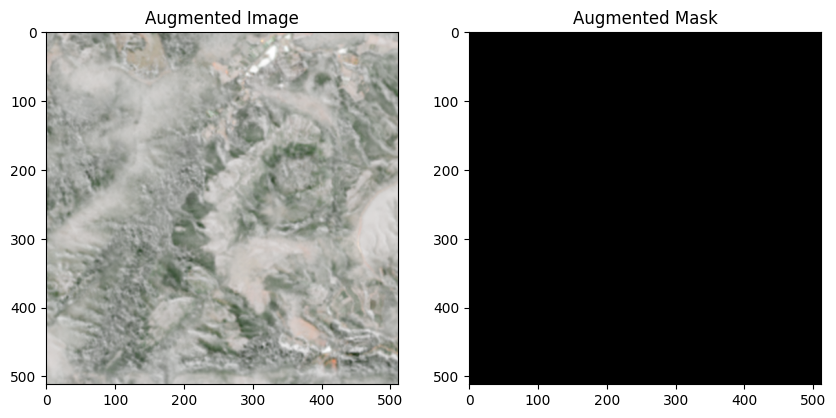

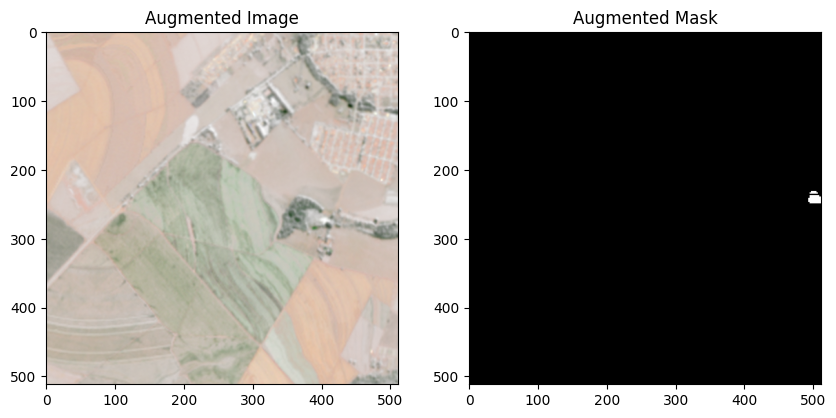

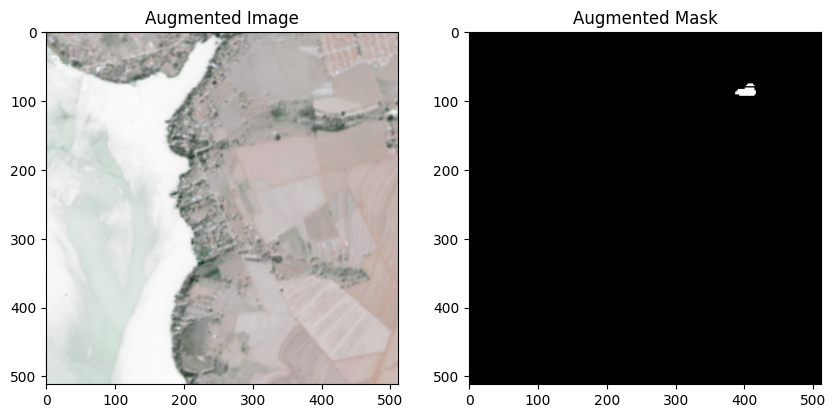

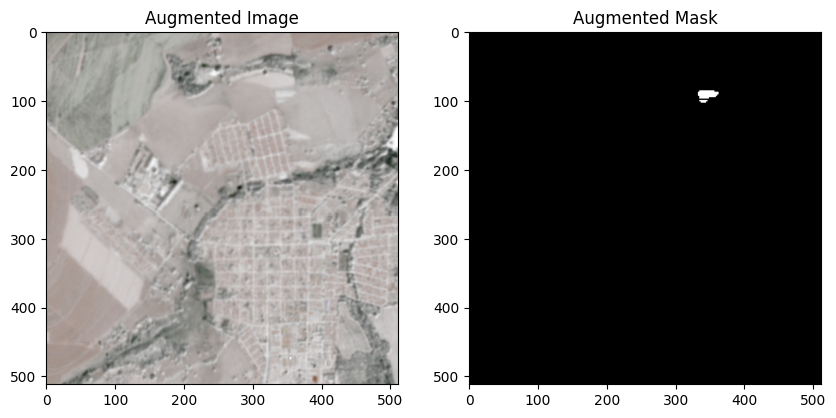

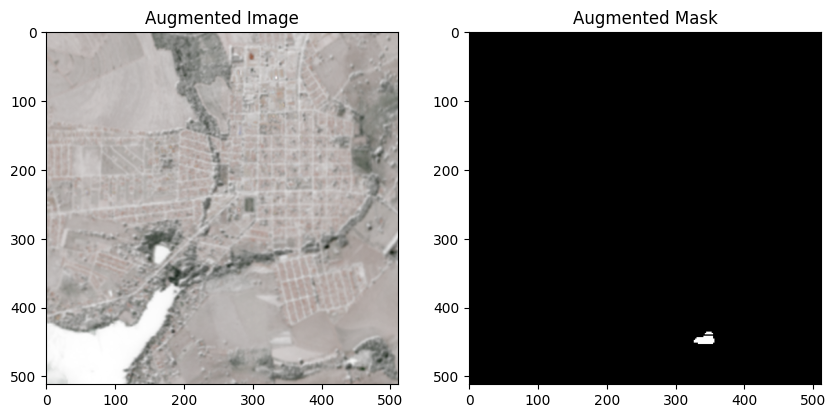

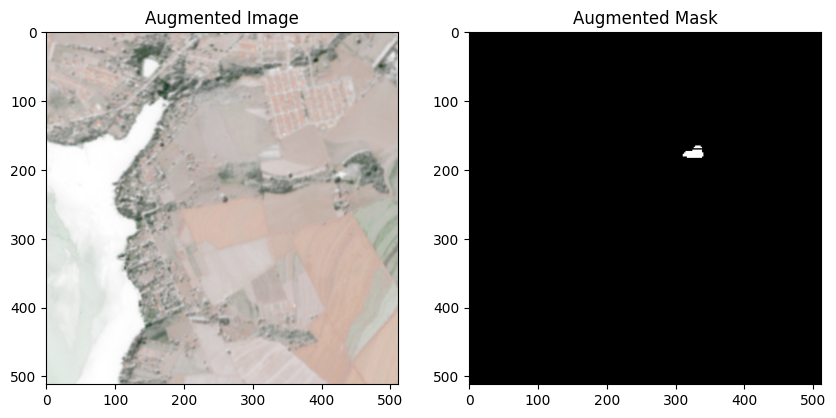

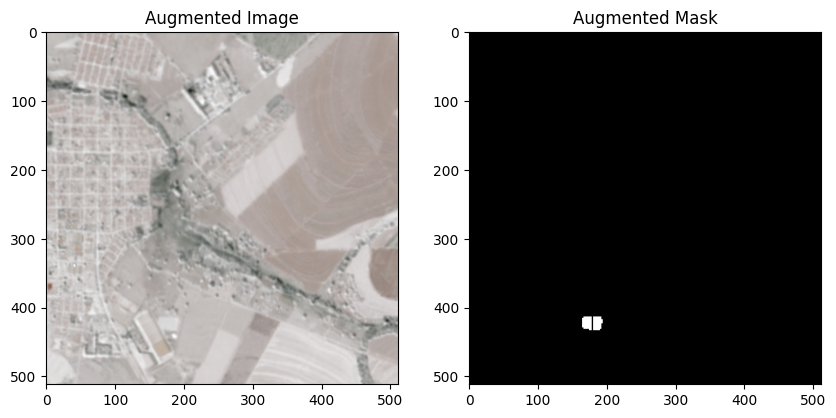

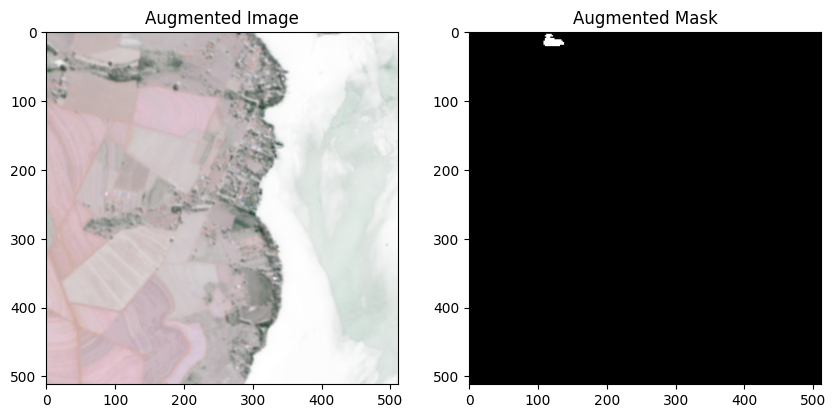

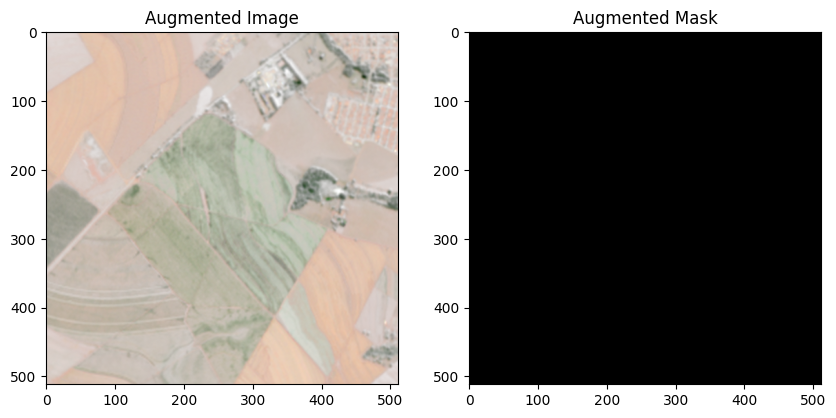

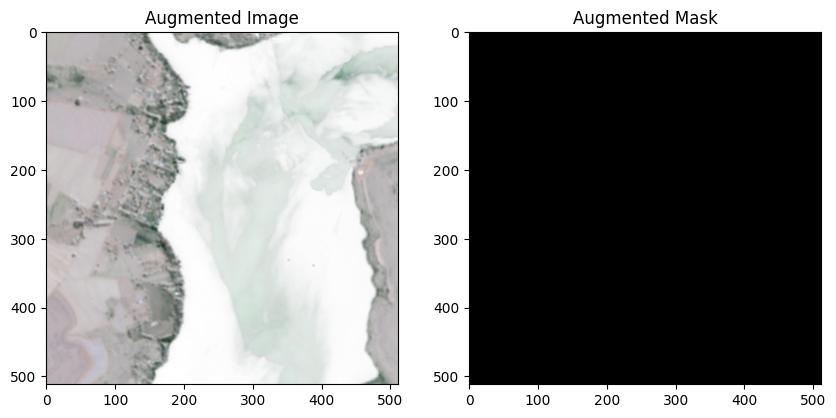

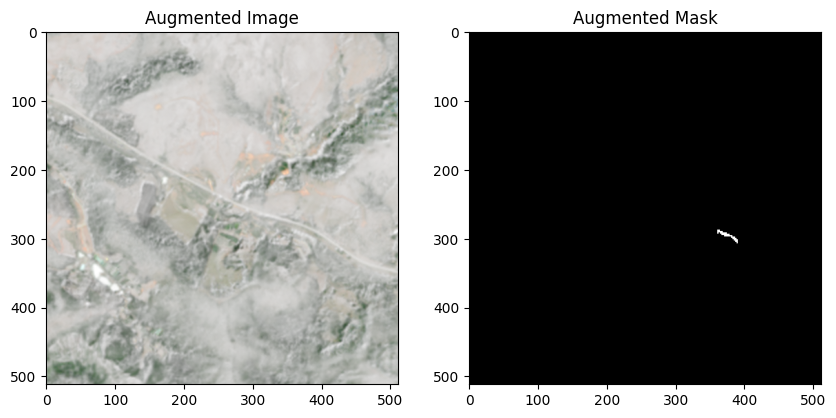

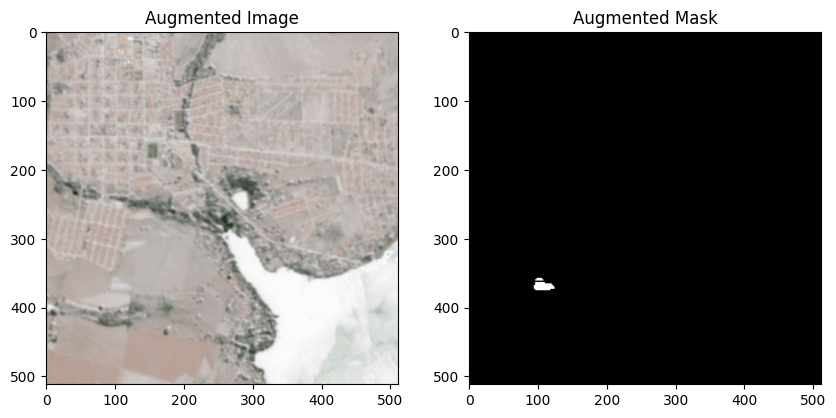

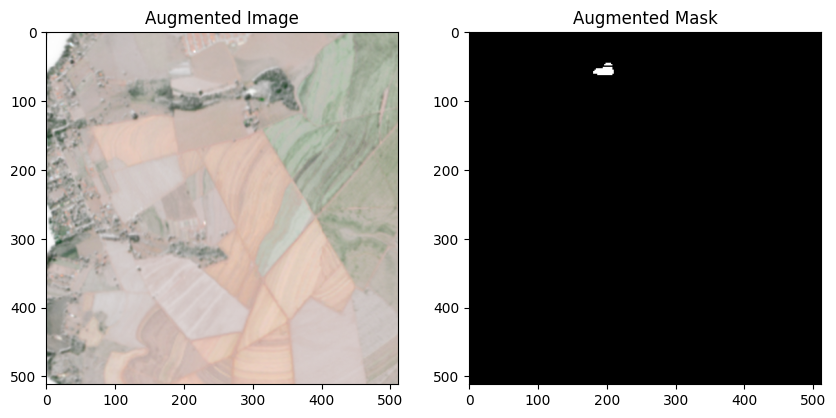

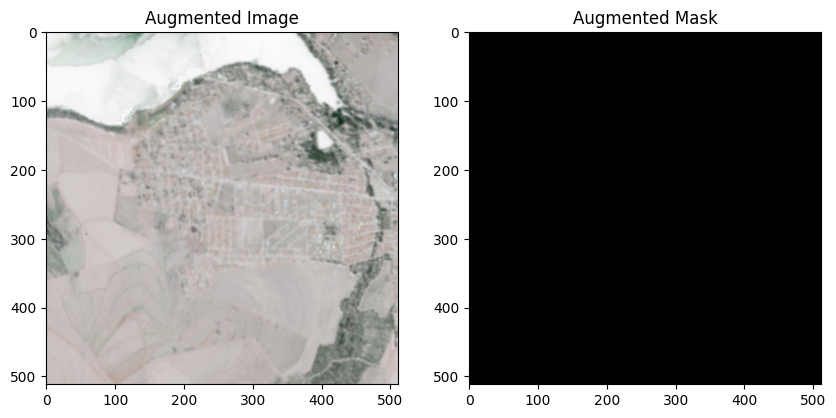

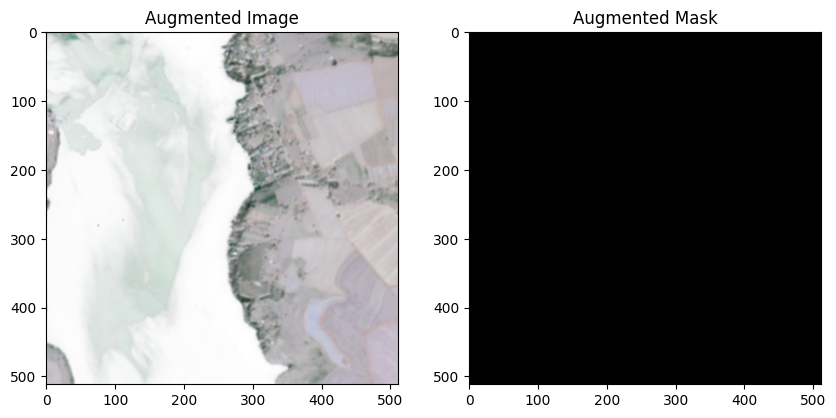

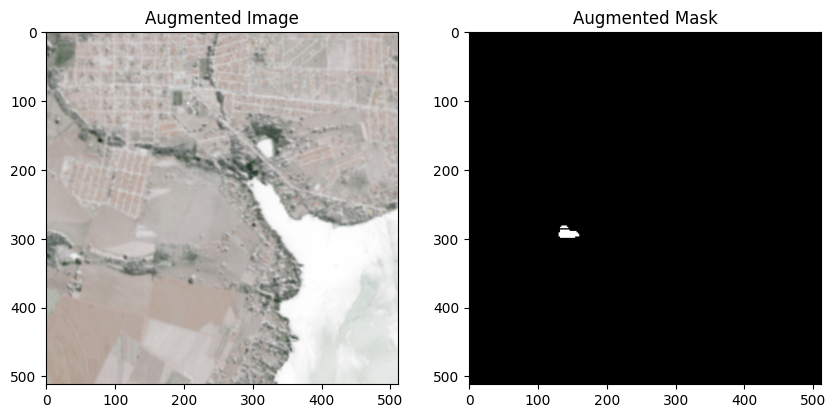

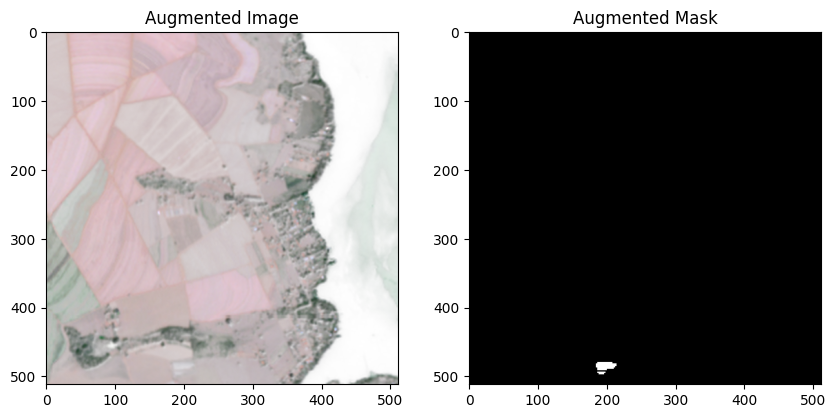

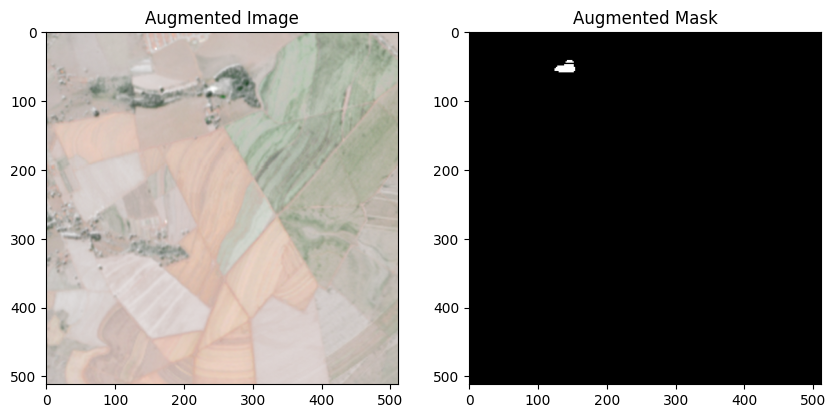

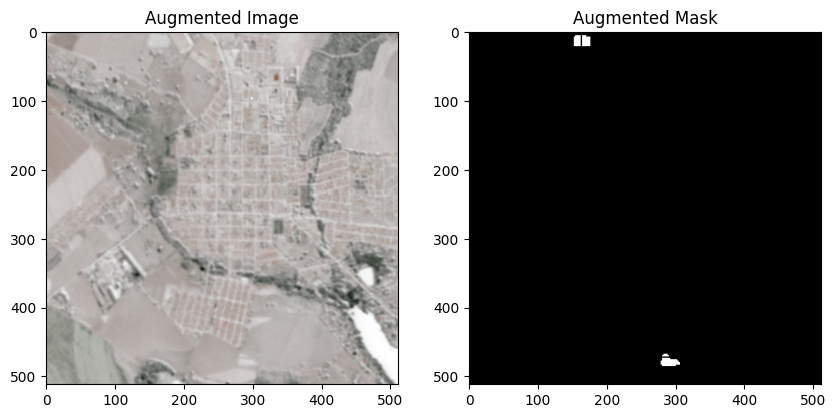

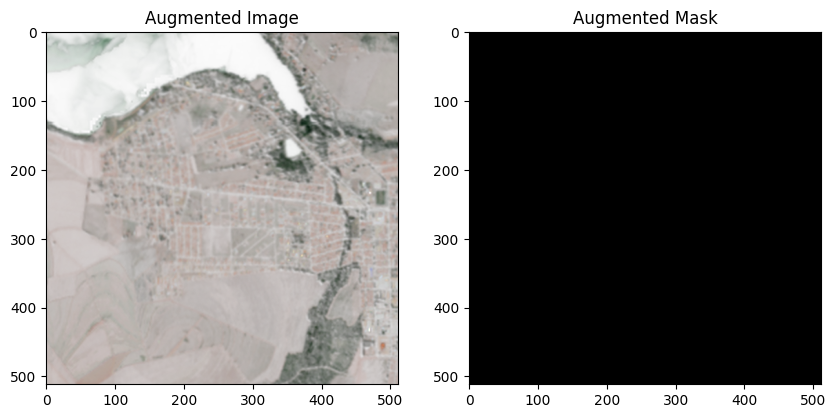

In [22]:
visualize_augmentations(train_dataset, num_samples=20)

## Train the Selected Model with Data Augmentation

In [96]:
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['solar_panel']
ACTIVATION = 'sigmoid'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PRETRAINED_WEIGHTS_PATH = './models/weights/base/unet-seed23_wDA&Int_weights.pth'

model = smp.Unet(
    in_channels = 4 if use_all_bands else 1, #4 for all bands
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [70]:
model.load_state_dict(torch.load(PRETRAINED_WEIGHTS_PATH, map_location=DEVICE))


C:\Users\fpere\AppData\Local\Temp\ipykernel_24828\3861480228.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PRETRAINED_WEIGHTS_PATH, ma

<All keys matched successfully>

In [72]:
importlib.reload(S7_tools)
from S7_tools import WeightedBCELoss, BCEFocalNegativeIoULoss, compute_class_aware_iou, train_loop, plot_loss_and_metrics



In [74]:
import gc  # For garbage collection

# Following, we incorporate these steps before start training a new model. 
# This helps optimize GPU memory usage and avoid potential slowdowns during subsequent training runs.

# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()

# Reset GradScaler
scaler = torch.amp.GradScaler('cuda')

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=0.00005,     # lower learning rate for re-training          
    weight_decay=1e-6        
    )

loss = BCEFocalNegativeIoULoss(alpha=0.8, gamma=2)

# Adjusts every 'step_size' epochs, decreasing by 'gamma'*100 %
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Reset the dataset loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=5, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=40, shuffle=False, num_workers=0)

In [76]:
train_losses, train_ious, valid_losses, valid_ious, _, _ = \
train_loop(model = model, 
           train_loader = train_loader, 
           valid_loader = valid_loader, 
           test_loader = test_loader, 
           optimizer = optimizer, 
           loss = loss, 
           scheduler = scheduler, 
           early_stopping_patience = 20, 
           early_stopping_min_delta = 0.0001, 
           model_filename = './models/weights/re-trained/Unet_wDA_effb7_base_re-train.pth', 
           device = DEVICE)


Epoch: 0
Discard 0s? True	| 0s_masks/Tot_imgs: 89/258 	|| Train Loss: 0.017549 | Train IoU: 0.861
Skipped batch with all all-background images.
Discard 0s? True	| 0s_masks/Tot_imgs: 14/45 	|| Valid Loss: 0.015920 | Valid IoU: 0.864
Model saved!

Epoch: 1
Discard 0s? True	| 0s_masks/Tot_imgs: 89/258 	|| Train Loss: 0.017278 | Train IoU: 0.868
Skipped batch with all all-background images.
Discard 0s? True	| 0s_masks/Tot_imgs: 14/45 	|| Valid Loss: 0.019798 | Valid IoU: 0.845

Epoch: 2
Discard 0s? True	| 0s_masks/Tot_imgs: 89/258 	|| Train Loss: 0.016233 | Train IoU: 0.870
Skipped batch with all all-background images.
Discard 0s? True	| 0s_masks/Tot_imgs: 14/45 	|| Valid Loss: 0.017326 | Valid IoU: 0.855

Epoch: 3
Discard 0s? True	| 0s_masks/Tot_imgs: 89/258 	|| Train Loss: 0.016133 | Train IoU: 0.866
Skipped batch with all all-background images.
Discard 0s? True	| 0s_masks/Tot_imgs: 14/45 	|| Valid Loss: 0.017370 | Valid IoU: 0.846

Epoch: 4
Discard 0s? True	| 0s_masks/Tot_imgs: 89/258 

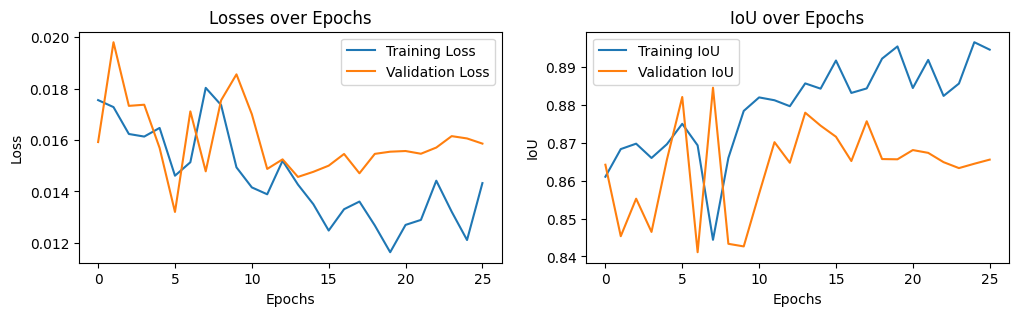

In [78]:
plot_loss_and_metrics(train_losses, train_ious, valid_losses, valid_ious)

In [80]:
torch.save(model.state_dict(), "./models/weights/base/unet-seed23_wDA&Int_weights.pth")
torch.save(optimizer.state_dict(), "./models/weights/base/unet-seed23_wDA&Int_weights-optimizer.pth")


In [82]:
importlib.reload(S7_tools)
from S7_tools import compute_confusion_matrix_with_distributions, display_confusion_matrix_with_metrics_and_distributions

Test loader dataset size: 47
Batch size: 40, Total batches: 2
Processing batch 1/2: 40 images.
Batch 1 shapes - preds: torch.Size([40, 1, 512, 512]), masks: torch.Size([40, 1, 512, 512])
Flattened batch 1 shapes - preds: (10485760,), masks: (10485760,)
Processing batch 2/2: 7 images.
Batch 2 shapes - preds: torch.Size([7, 1, 512, 512]), masks: torch.Size([7, 1, 512, 512])
Flattened batch 2 shapes - preds: (1835008,), masks: (1835008,)
Final concatenated shapes - all_preds: (12320768,), all_masks: (12320768,)
----------------------------------------------------------------------
TP:655518	TN:11585595	FP:55765		FN:23890
----------------------------------------------------------------------


Accuracy:     0.9935	               (TP + TN) / (TP + TN + FP + FN)
Recall:       0.9648	                      TP / (TP + FN)
Specificity:  0.9952	                      TN / (TN + FP)
Precision:    0.9216	                      TP / (TP + FP)
F1-Score:     0.9427	    (2*precision*recall) / (precision 

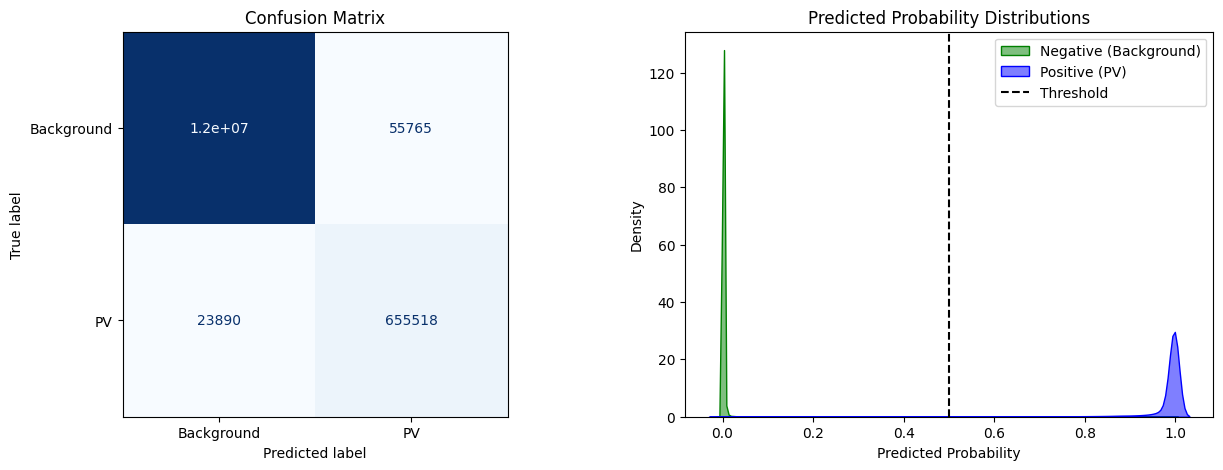

In [84]:
# Compute Confusion Matrix and plot
cm, pos_probs, neg_probs, nb_of_images_eval = compute_confusion_matrix_with_distributions(model, test_loader, DEVICE)
display_confusion_matrix_with_metrics_and_distributions(cm, pos_probs, neg_probs, nb_of_images_eval)

In [24]:
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['solar_panel']
ACTIVATION = 'sigmoid'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = smp.Unet(
    in_channels = 4 if use_all_bands else 1, #4 for all bands
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [26]:
importlib.reload(S7_tools)
from S7_tools import WeightedBCELoss, BCEFocalNegativeIoULoss, compute_class_aware_iou, train_loop, plot_loss_and_metrics


In [28]:
import gc  # For garbage collection

# Following, we incorporate these steps before start training a new model. 
# This helps optimize GPU memory usage and avoid potential slowdowns during subsequent training runs.

# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()

# Reset GradScaler
scaler = torch.amp.GradScaler('cuda')

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=0.0001,     # lower learning rate for re-training          
    weight_decay=1e-6        
    )

loss = BCEFocalNegativeIoULoss(alpha=0.8, gamma=2)

# Adjusts every 'step_size' epochs, decreasing by 'gamma'*100 %
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Reset the dataset loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=5, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=40, shuffle=False, num_workers=0)

In [30]:
train_losses, train_ious, valid_losses, valid_ious, _, _ = \
train_loop(model = model, 
           train_loader = train_loader, 
           valid_loader = valid_loader, 
           test_loader = test_loader, 
           optimizer = optimizer, 
           loss = loss, 
           scheduler = scheduler, 
           early_stopping_patience = 20, 
           early_stopping_min_delta = 0.0001, 
           model_filename = './models/weights/re-trained/Unet_wDA_effb7_base_alpha5_10-6_re-train.pth', 
           device = DEVICE)


Epoch: 0
Discard 0s? True	| 0s_masks/Tot_imgs: 89/258 	|| Train Loss: 0.197769 | Train IoU: 0.038
Skipped batch with all all-background images.
Discard 0s? True	| 0s_masks/Tot_imgs: 14/45 	|| Valid Loss: 0.143349 | Valid IoU: 0.083
Model saved!

Epoch: 1
Discard 0s? True	| 0s_masks/Tot_imgs: 89/258 	|| Train Loss: 0.141149 | Train IoU: 0.159
Skipped batch with all all-background images.
Discard 0s? True	| 0s_masks/Tot_imgs: 14/45 	|| Valid Loss: 0.120979 | Valid IoU: 0.183
Model saved!

Epoch: 2
Discard 0s? True	| 0s_masks/Tot_imgs: 89/258 	|| Train Loss: 0.113034 | Train IoU: 0.302
Skipped batch with all all-background images.
Discard 0s? True	| 0s_masks/Tot_imgs: 14/45 	|| Valid Loss: 0.087730 | Valid IoU: 0.448
Model saved!

Epoch: 3
Discard 0s? True	| 0s_masks/Tot_imgs: 89/258 	|| Train Loss: 0.098238 | Train IoU: 0.373
Skipped batch with all all-background images.
Discard 0s? True	| 0s_masks/Tot_imgs: 14/45 	|| Valid Loss: 0.070319 | Valid IoU: 0.594
Model saved!

Epoch: 4
Discar

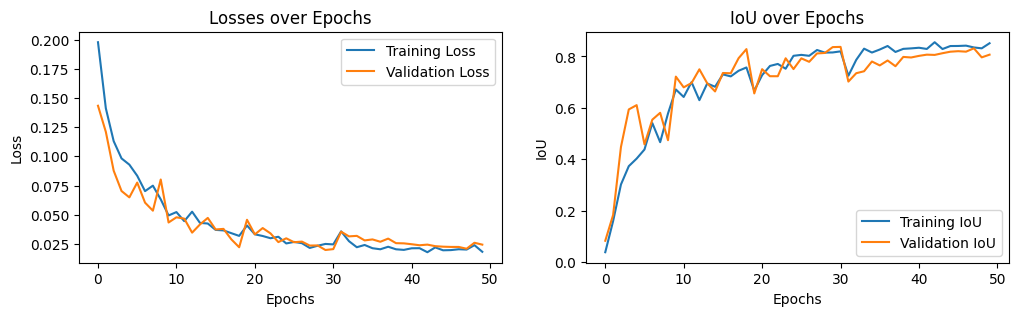

In [32]:
plot_loss_and_metrics(train_losses, train_ious, valid_losses, valid_ious)

In [34]:
torch.save(model.state_dict(), "./models/weights/re-trained/Unet_wDA_effb7_base_alpha5_10-6_re-train.pth")
torch.save(optimizer.state_dict(), "./models/weights/re-trained/Unet_wDA_effb7_base_alpha5_10-6_re-train-optimizer.pth")


In [36]:
importlib.reload(S7_tools)
from S7_tools import compute_confusion_matrix_with_distributions, display_confusion_matrix_with_metrics_and_distributions

Test loader dataset size: 47
Batch size: 40, Total batches: 2
Processing batch 1/2: 40 images.
Batch 1 shapes - preds: torch.Size([40, 1, 512, 512]), masks: torch.Size([40, 1, 512, 512])
Flattened batch 1 shapes - preds: (10485760,), masks: (10485760,)
Processing batch 2/2: 7 images.
Batch 2 shapes - preds: torch.Size([7, 1, 512, 512]), masks: torch.Size([7, 1, 512, 512])
Flattened batch 2 shapes - preds: (1835008,), masks: (1835008,)
Final concatenated shapes - all_preds: (12320768,), all_masks: (12320768,)
----------------------------------------------------------------------
TP:646043	TN:11597767	FP:43593		FN:33365
----------------------------------------------------------------------


Accuracy:     0.9938	               (TP + TN) / (TP + TN + FP + FN)
Recall:       0.9509	                      TP / (TP + FN)
Specificity:  0.9963	                      TN / (TN + FP)
Precision:    0.9368	                      TP / (TP + FP)
F1-Score:     0.9438	    (2*precision*recall) / (precision 

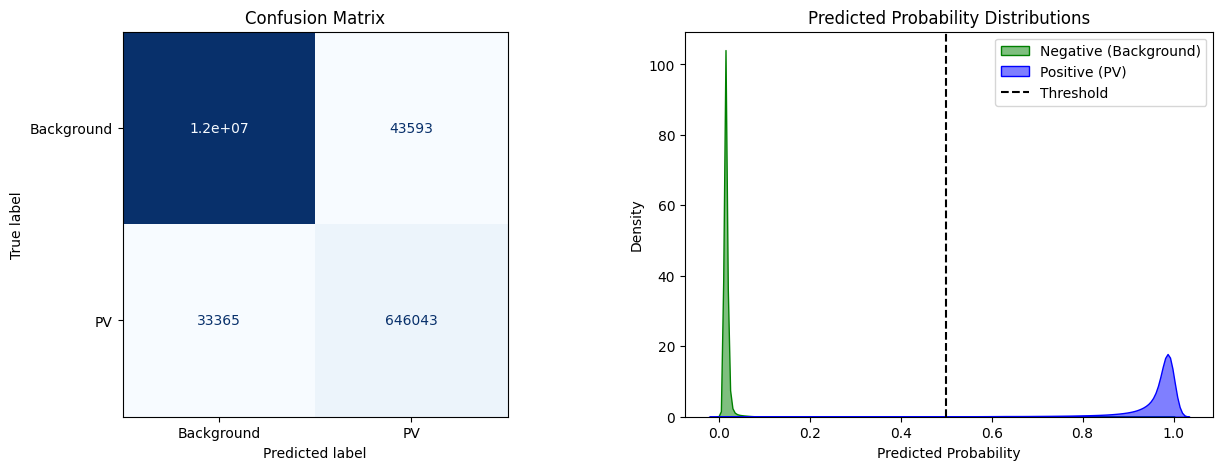

In [38]:
# Compute Confusion Matrix and plot
cm, pos_probs, neg_probs, nb_of_images_eval = compute_confusion_matrix_with_distributions(model, test_loader, DEVICE)
display_confusion_matrix_with_metrics_and_distributions(cm, pos_probs, neg_probs, nb_of_images_eval)

## 5- Applying Bicubic Interpolation to the datasets

In this section, we applied Bicubic Interpolation to all the images in the dataset, scaling them by a factor of 2, converting the original image size from 256×256 to 512×512. To avoid processing bottlenecks, we opted to pre-process the images by applying interpolation beforehand, rather than upscaling each image during the training loop.

In [55]:
# Function to extract the numeric value from filenames
def numeric_sort_key(filepath):
    # Extract numbers from the filename using a regular expression
    match = re.search(r'\d+', filepath)
    # Return the integer value of the number if found, otherwise 0
    return int(match.group()) if match else 0

# Get all the image and mask paths and sort them numerically
folder_data_train = sorted(
    glob.glob("../5-Data_Wrangling/data_split2sr/train/input/*tif"),
    key=numeric_sort_key
)
folder_mask_train = sorted(
    glob.glob("../5-Data_Wrangling/data_split2sr/train/labels/*tif"),
    key=numeric_sort_key
)

folder_data_val = sorted(
    glob.glob("../5-Data_Wrangling/data_split2sr/val/input/*tif"),
    key=numeric_sort_key
)
folder_mask_val = sorted(
    glob.glob("../5-Data_Wrangling/data_split2sr/val/labels/*tif"),
    key=numeric_sort_key
)

folder_data_test = sorted(
    glob.glob("../5-Data_Wrangling/data_split2sr/test/input/*tif"),
    key=numeric_sort_key
)
folder_mask_test = sorted(
    glob.glob("../5-Data_Wrangling/data_split2sr/test/labels/*tif"),
    key=numeric_sort_key
)

# Assign to variables
train_image_paths = folder_data_train[:]
val_image_paths = folder_data_val[:]
test_image_paths = folder_data_test[:]

train_mask_paths = folder_mask_train[:]
val_mask_paths = folder_mask_val[:]
test_mask_paths = folder_mask_test[:]


In [57]:
train_dataset = CustomDataset(train_image_paths, train_mask_paths, transform=augmentation_transform, band=model_band)
val_dataset = CustomDataset(val_image_paths, val_mask_paths, transform=simple_transform, band=model_band)
test_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=simple_transform, band=model_band)

In [59]:
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['solar_panel']
ACTIVATION = 'sigmoid'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = smp.Unet(
    in_channels = 4 if use_all_bands else 1, #4 for all bands
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [63]:
importlib.reload(S7_tools)
from S7_tools import WeightedBCELoss, BCEFocalNegativeIoULoss, compute_class_aware_iou, train_loop, plot_loss_and_metrics

In [65]:
# Following, we incorporate these steps before start training a new model. 
# This helps optimize GPU memory usage and avoid potential slowdowns during subsequent training runs.

# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()

# Reset GradScaler
scaler = torch.amp.GradScaler('cuda')

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=0.0001,               
    weight_decay=1e-6        
    )

loss = BCEFocalNegativeIoULoss(alpha=0.8, gamma=2)

# Adjusts every 'step_size' epochs, decreasing by 'gamma'*100 %
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Reset the dataset loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=5, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=40, shuffle=False, num_workers=0)

In [67]:
train_losses, train_ious, valid_losses, valid_ious, _, _ = \
train_loop(model = model, 
           train_loader = train_loader, 
           valid_loader = valid_loader, 
           test_loader = test_loader, 
           optimizer = optimizer, 
           loss = loss, 
           scheduler = scheduler, 
           early_stopping_patience = 20, 
           early_stopping_min_delta = 0.0001, 
           model_filename = './models/Unet_wDA&Int_effb7.pth', 
           device = DEVICE)


Epoch: 0
Discard 0s? True	| 0s_masks/Tot_imgs: 32/201 	|| Train Loss: 0.145373 | Train IoU: 0.046
Discard 0s? True	| 0s_masks/Tot_imgs: 4/35 	|| Valid Loss: 0.120096 | Valid IoU: 0.196
Model saved!

Epoch: 1
Discard 0s? True	| 0s_masks/Tot_imgs: 32/201 	|| Train Loss: 0.114761 | Train IoU: 0.158
Discard 0s? True	| 0s_masks/Tot_imgs: 4/35 	|| Valid Loss: 0.079173 | Valid IoU: 0.521
Model saved!

Epoch: 2
Skipped batch with all all-background images.
Discard 0s? True	| 0s_masks/Tot_imgs: 32/201 	|| Train Loss: 0.085753 | Train IoU: 0.359
Discard 0s? True	| 0s_masks/Tot_imgs: 4/35 	|| Valid Loss: 0.064363 | Valid IoU: 0.610
Model saved!

Epoch: 3
Skipped batch with all all-background images.
Discard 0s? True	| 0s_masks/Tot_imgs: 32/201 	|| Train Loss: 0.070585 | Train IoU: 0.472
Discard 0s? True	| 0s_masks/Tot_imgs: 4/35 	|| Valid Loss: 0.056533 | Valid IoU: 0.640
Model saved!

Epoch: 4
Discard 0s? True	| 0s_masks/Tot_imgs: 32/201 	|| Train Loss: 0.061759 | Train IoU: 0.562
Discard 0s? T

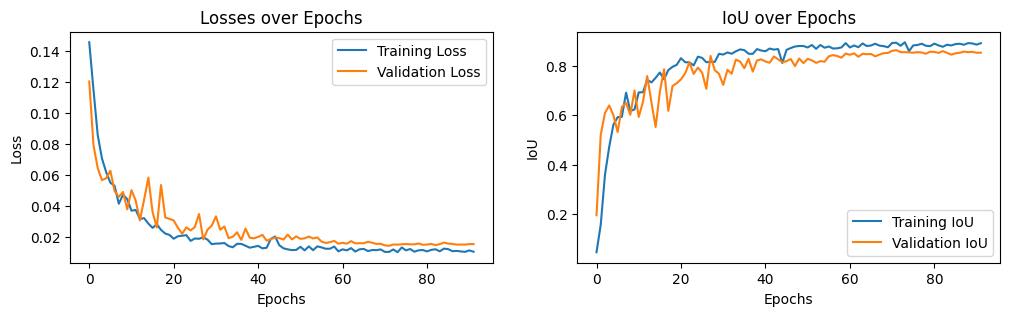

In [69]:
plot_loss_and_metrics(train_losses, train_ious, valid_losses, valid_ious)

In [71]:
torch.save(model.state_dict(), "unet-seed23_wDA&Int_weights.pth")
torch.save(optimizer.state_dict(), "unet-seed23_wDA&Int-optimizer_state.pth")

Test loader dataset size: 36
Batch size: 40, Total batches: 1
Processing batch 1/1: 36 images.
Batch 1 shapes - preds: torch.Size([36, 1, 512, 512]), masks: torch.Size([36, 1, 512, 512])
Flattened batch 1 shapes - preds: (9437184,), masks: (9437184,)
Final concatenated shapes - all_preds: (9437184,), all_masks: (9437184,)
----------------------------------------------------------------------
TP:660583	TN:8739023	FP:18753		FN:18825
----------------------------------------------------------------------


Accuracy:     0.9960	               (TP + TN) / (TP + TN + FP + FN)
Recall:       0.9723	                      TP / (TP + FN)
Specificity:  0.9979	                      TN / (TN + FP)
Precision:    0.9724	                      TP / (TP + FP)
F1-Score:     0.9723	    (2*precision*recall) / (precision + recall)
IoU:          0.9462	                      TP / (TP + FN + FP)





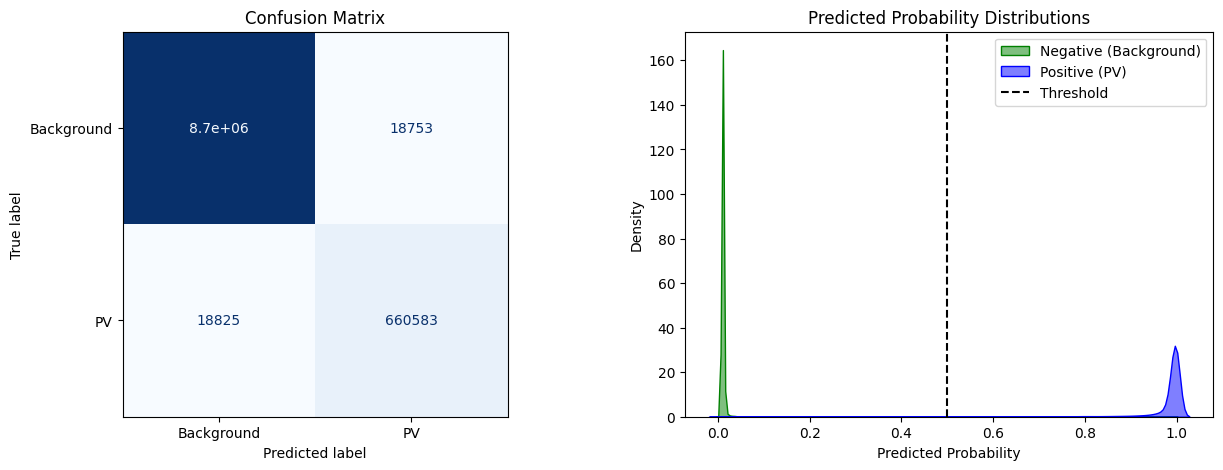

In [73]:
# Compute Confusion Matrix and plot
cm, pos_probs, neg_probs, nb_of_images_eval = compute_confusion_matrix_with_distributions(model, test_loader, DEVICE)
display_confusion_matrix_with_metrics_and_distributions(cm, pos_probs, neg_probs, nb_of_images_eval)

## 4- Compare Results

Below are the results obtained:

![Model Results](sup_images/results_part2.png)

With Data Augmentation (Row 2): Data augmentation improved precision (0.9907) and specificity (0.9994) while significantly reducing false positives. However, it negatively impacted recall (0.8760) and overall balance, as reflected in the F1-Score (0.9298) and IoU (0.8689).

With Data Augmentation and Bicubic Interpolation (Row 3): Adding 2× Bicubic Interpolation (resulting in images 4 times larger) greatly improved recall (0.9723), F1-Score (0.9723), and IoU (0.9462), showcasing the model's enhanced ability to detect true positives. However, the number of false positives (FP) and false negatives (FN) is no longer directly comparable to previous rows due to the increased image size. This setup achieved the best overall balance between precision and recall.


